In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
#!pip install transformers

In [2]:
import sys
BASE_PATH = "/content/drive/My Drive/collab/"
BASE_PATH = "/Users/samir/Dev/projects/MIMIC/"
data_path = BASE_PATH+"MIMIC/DATA/input/"
sys.path.append(BASE_PATH+"TADAT/") 

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from pdb import set_trace
import pandas as pd
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import warnings

#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def vectorize_data(train_split, test_split, test_split_G, test_split_O):
    #vectorize instances
    train_X = data.getX(train_split)
    test_X_G = data.getX(test_split_G)
    test_X_O = data.getX(test_split_O)
    test_X = data.getX(test_split)
    
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X_G,_ = vectorizer.docs2idx(test_X_G, word_vocab)
    test_X_O,_ = vectorizer.docs2idx(test_X_O, word_vocab)
    test_X,_ = vectorizer.docs2idx(test_X, word_vocab)
    
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y_G = data.getY(test_split_G) 
    test_Y_O = data.getY(test_split_O)   
    test_Y = data.getY(test_split)   
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_G,_ = vectorizer.label2idx(test_Y_G, label_vocab)
    test_Y_O,_ = vectorizer.label2idx(test_Y_O, label_vocab)
    
    return train_X, train_Y, test_X, test_Y, test_X_G, test_Y_G, test_X_O, test_Y_O, word_vocab, label_vocab

def vectorize_labels(train_split, test_split, test_split_G, test_split_O):
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y_G = data.getY(test_split_G) 
    test_Y_O = data.getY(test_split_O)   
    test_Y = data.getY(test_split)   
    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    test_Y_G,_ = vectorizer.label2idx(test_Y_G, label_vocab)
    test_Y_O,_ = vectorizer.label2idx(test_Y_O, label_vocab)
    
    return train_Y, test_Y, test_Y_G, test_Y_O

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-bin":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-freq":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-bin":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-sum": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    
def get_BERT_embedding(X):
    X_cls, X_pool =  embeddings.transformer_encode_batches(X, batchsize=200, device="cuda")
    return X_cls, X_pool
    

def evaluate_classifier(model, X_test, Y_test,
                   labels, model_name, random_seed, res_path=None):
    Y_hat = model.predict(X_test)
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3), \
            "macroF1":round(macroF1,3)
            }

    for l, i in labels.items():
        try:
            fs = round(fscore[i],3)
        except IndexError:
            fs = 0
        res["{}-f1".format(l)] = fs
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]        
        helpers.save_results(res, res_path, sep="\t")
    return res


def get_deltas(results_G, results_O):
    #resuts
    df_G = pd.DataFrame(results_G)
    df_O = pd.DataFrame(results_O)
    #compute deltas
    df_delta = df_G.sub(df_O.iloc[:,2:])
    df_delta["model"] = df_G["model"]
    df_delta["seed"] = df_G["seed"]   
    return df_delta

def run_finebert(df_train, df_test, df_val, x_label, y_label, feature_type, group_label, subgroup, split=0.8):
    #split data into "group" and "others"
    df_test_G = df_test[df_test[group_label] == subgroup]
    df_test_O = df_test[df_test[group_label] != subgroup]    
    print("{}: {} | others: {}".format(subgroup,len(df_test_G),len(df_test_O)))
    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_G = data.read_dataframe(df_test_G, x_label, y_label)
    test_O = data.read_dataframe(df_test_O, x_label, y_label)
    test = data.read_dataframe(df_test, x_label, y_label)
    val = data.read_dataframe(df_val, x_label, y_label)
    #get vectorized labels
    train_Y, test_Y, test_Y_G, test_Y_O, label_vocab = vectorize_labels(train, test, test_G, test_O)
    #get instances
    train_X = data.getX(train)
    test_X_G = data.getX(test_G)
    test_X_O = data.getX(test_O)
    test_X = data.getX(test)
    val_X = data.getX(val)    
    all_docs = np.concatenate([train_X,test_X,val_X])
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    max_len = berter.max_doc_len(all_docs, tokenizer)
    print('Max length: ', max_len)
    #vectorize data
    train_inputs, train_masks, train_labels = berter.vectorize(X_train, y_train, tokenizer, max_len)
    val_inputs, val_masks, val_labels = berter.vectorize(X_val, y_val, tokenizer, max_len)
    BATCH_SIZE = 32
    # Create the DataLoader for training and validation sets
    train_dataloader = berter.get_random_sample_loader(train_inputs, train_masks, train_labels, BATCH_SIZE)
    val_dataloader = berter.get_sequential_sample_loader(val_inputs, val_masks, val_labels, BATCH_SIZE)
    #train/test classifier for each random seed
    random_seeds = list(range(20))
    results = []
    results_g = []
    results_o = []    
    for r in random_seeds:
        model = SGDClassifier(random_state=r)
        model.fit(train_feats, train_Y)
        res = evaluate_classifier(model, test_feats, test_Y, label_vocab, feature_type, r)
        results.append(res)
        res_g = evaluate_classifier(model, test_feats_G, test_Y_G, label_vocab, feature_type, r)
        results_g.append(res_g)
        res_o = evaluate_classifier(model, test_feats_O, test_Y_O, label_vocab, feature_type, r)
        results_o.append(res_o)
    return results, results_g, results_o

def run(df_train, df_test, df_val, x_label, y_label, feature_type, group_label, subgroup, split=0.8):

    df_test_G = df_test[df_test[group_label] == subgroup]
    df_test_O = df_test[df_test[group_label] != subgroup]
    
    print("{}: {} | others: {}".format(subgroup,len(df_test_G),len(df_test_O)))
    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_G = data.read_dataframe(df_test_G, x_label, y_label)
    test_O = data.read_dataframe(df_test_O, x_label, y_label)
    test = data.read_dataframe(df_test, x_label, y_label)
    #get vectorized train/test data 
    train_X, train_Y, test_X, test_Y, test_X_G, test_Y_G, test_X_O, test_Y_O, word_vocab, label_vocab = vectorize_data(train, test, test_G, test_O)

    if "BOW" in feature_type:
        #extract features
        train_feats = get_features(train_X, len(word_vocab), feature_type)
        test_feats_G = get_features(test_X_G, len(word_vocab), feature_type)
        test_feats_O = get_features(test_X_O, len(word_vocab), feature_type)        
        test_feats = get_features(test_X, len(word_vocab), feature_type)        
    elif "BERT_CLS" == feature_type:
        train_feats, _ = get_BERT_embedding(train)
        test_feats_G, _ = get_BERT_embedding(test_G)
        test_feats_O, _ = get_BERT_embedding(test_O)
        test_feats, _ = get_BERT_embedding(test)
    elif "BERT_POOL" == feature_type:
        _, train_feats = get_BERT_embedding(train)
        _, test_feats_G = get_BERT_embedding(test_G)
        _, test_feats_O = get_BERT_embedding(test_O)
        _, test_feats = get_BERT_embedding(test)
    else:
        raise NotImplementedError    

    #train/test classifier for each random seed
    random_seeds = list(range(20))
    results = []
    results_g = []
    results_o = []
    
    for r in random_seeds:
        model = SGDClassifier(random_state=r)
        model.fit(train_feats, train_Y)
        res = evaluate_classifier(model, test_feats, test_Y, label_vocab, feature_type, r)
        results.append(res)
        res_g = evaluate_classifier(model, test_feats_G, test_Y_G, label_vocab, feature_type, r)
        results_g.append(res_g)
        res_o = evaluate_classifier(model, test_feats_O, test_Y_O, label_vocab, feature_type, r)
        results_o.append(res_o)
    return results, results_g, results_o


def plot_densities(df, ax, title):
    ax.set_title(title)
    try:
        df.plot.kde(ax=ax, x="seed", y="macroF1")
    except:
        pass
    try:
        df.plot.kde(ax=ax, x="seed", y="0-f1")
    except:
        pass
    try:
        df.plot.kde(ax=ax, x="seed", y="1-f1")
    except:
        pass

def plot_performance(df, title):
    #plots
    fig, ax = plt.subplots(1,2, figsize=(18,5))
#   plots.plot_df(df=df,ax=ax,x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df,ax=ax[0],x="seed",ys=["macroF1","0-f1","1-f1"], annotation_size=10)
    fig.suptitle(title ,y=1.02)
    plot_densities(df, ax[1], "") 
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    plt.tight_layout()

def plot_density(df, title, ax=None):
    if not ax:
        fig, ax = plt.subplots(1,1, sharey=True, sharex=True, figsize=(18,5))
        fig.suptitle(title ,y=1.02)

    plt.tight_layout()

def read_dataset(path, dataset_name):
    df_train = pd.read_csv("{}/{}_train.csv".format(path, dataset_name), sep="\t", header=0)
    df_test  = pd.read_csv("{}/{}_test.csv".format(path, dataset_name), sep="\t", header=0)
    df_val   = pd.read_csv("{}/{}_val.csv".format(path, dataset_name), sep="\t", header=0)
    return df_train, df_test, df_val
    

# Analyses

## Gender 

In [5]:
def gender_outcomes(data_path, dataset, x_label, y_label, feature_type):
    df_train, df_test, df_val = read_dataset(data_path, dataset)
    results, results_M, results_F = run(df_train, df_test, df_val, x_label, y_label, feature_type, "GENDER", "M", split=0.8)
    #results
    df_delta = get_deltas(results_M,results_F)    
    df_res = pd.DataFrame(results)    
    df_res_M = pd.DataFrame(results_M)
    df_res_F = pd.DataFrame(results_F)
    
    return df_res, df_res_M, df_res_F, df_delta
    
def gender_plot_deltas(df_delta, title):
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model"], value_vars=["macroF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")
    
    lim = max(df_delta_long["delta"].abs()) + 0.05
    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, sharey=True,legend_out=True)
    ax1 = g.axes[0][0]
    ax1.axhline(0, ls='--',c="r")
    ax1.set_ylim([-lim,lim])
    plt.suptitle(title,y=1.02)
    plt.tight_layout()
    plt.show()  

def gender_plot_densities(df_M, df_F, title):
    #plots
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_M, ax[0], "Male") 
    plot_densities(df_F, ax[1], "Female") 
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()

def gender_analysis(data_path, dataset, x_label, y_label, feature_type, outcome_title):
    df_res, df_res_M, df_res_F, df_res_delta = gender_outcomes(data_path, dataset, x_label, y_label, feature_type)
    title="{} ({})".format(outcome_title, feature_type)
    plot_performance(df_res, title)
#     plot_density(df_res, title)
    gender_plot_densities(df_res_M, df_res_F, title)
    gender_plot_deltas(df_res_delta, title)
    

    

## Ethnicity Binary

In [6]:
def ethnicity_binary_outcomes(data_path, dataset, x_label, y_label, feature_type):
    df_train, df_test, df_val = read_dataset(data_path, dataset)
    results_W, results_G_W, results_O_W = run(df_train, df_test, df_val, x_label, y_label, feature_type, "ETHNICITY_BINARY", "WHITE", split=0.8)
    results_N, results_G_N, results_O_N = run(df_train, df_test, df_val, x_label, y_label, feature_type, "ETHNICITY_BINARY", "NON-WHITE", split=0.8)
    #results
    df_delta_W = get_deltas(results_G_W,results_O_W)
    df_delta_N = get_deltas(results_G_N,results_O_N)    
    df_delta_W["group"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["group"] = ["Non-White v Others"]*len(df_delta_N)
    df_res = pd.DataFrame(results_W)    
    df_res_W = pd.DataFrame(results_G_W)
    df_res_N = pd.DataFrame(results_G_N)
    
    return df_res, df_res_W, df_res_N, df_delta_W, df_delta_N
    

def ethnicity_binary_plot_deltas(df_delta_W,df_delta_N, title):
    df_delta = pd.concat([df_delta_W,df_delta_N])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], value_vars=["macroF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")

    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, 
                    col="group",sharey=True,legend_out=True)
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    lim = max(df_delta_long["delta"].abs()) + 0.05
    ax1.set_ylim([-lim,lim])
    ax2.set_ylim([-lim,lim])
    plt.suptitle(title,y=1.02)
    plt.tight_layout()
    plt.show()  
    
def ethnicity_binary_plot_densities(df_W, df_N, title):
    #plots
    fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_W, ax[0], "White")
    plot_densities(df_N, ax[1], "Non-White")
    fig.suptitle(title ,y=1.02)
    plt.tight_layout()

def ethnicity_binary_analysis(data_path, dataset, x_label, y_label, feature_type, outcome_title):
    df_res, df_res_W, df_res_N, df_res_delta_W, df_res_delta_N = ethnicity_binary_outcomes(data_path, dataset, x_label, y_label, feature_type)
    title="{} ({})".format(outcome_title, feature_type)
    plot_performance(df_res, title)
#     plot_density(df_res, title)
    ethnicity_binary_plot_densities(df_res_W,df_res_N,title)
    ethnicity_binary_plot_deltas(df_res_delta_W, df_res_delta_N, title)
    

## Ethnicity 

In [7]:
def ethinicity_outcomes(data_path, dataset, x_label, y_label, feature_type):
    df_train, df_test, df_val = read_dataset(data_path, dataset)
    results_W, results_G_W, results_O_W = run(df_train, df_test, df_val, x_label, y_label, feature_type, "ETHNICITY_LABEL", "WHITE", split=0.8)
    results_N, results_G_N, results_O_N = run(df_train, df_test, df_val, x_label, y_label, feature_type, "ETHNICITY_LABEL", "BLACK", split=0.8)
    results_A, results_G_A, results_O_A = run(df_train, df_test, df_val, x_label, y_label, feature_type, "ETHNICITY_LABEL", "ASIAN", split=0.8)
    results_H, results_G_H, results_O_H = run(df_train, df_test, df_val, x_label, y_label, feature_type, "ETHNICITY_LABEL", "HISPANIC", split=0.8)

    #results
    df_delta_W = get_deltas(results_G_W,results_O_W)
    df_delta_N = get_deltas(results_G_N,results_O_N)
    df_delta_A = get_deltas(results_G_A,results_O_A)
    df_delta_H = get_deltas(results_G_H,results_O_H)

    df_res = pd.DataFrame(results_W)
    df_res_W = pd.DataFrame(results_G_W)
    df_res_N = pd.DataFrame(results_G_N)
    df_res_A = pd.DataFrame(results_G_A)
    df_res_H = pd.DataFrame(results_G_H)

    df_delta_W["group"] = ["White v Others"]*len(df_delta_W)
    df_delta_N["group"] = ["Black v Others"]*len(df_delta_N)
    df_delta_A["group"] = ["Asian v Others"]*len(df_delta_A)
    df_delta_H["group"] = ["Hispanic v Others"]*len(df_delta_H)
    
    return df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_delta_W, df_delta_N, df_delta_A, df_delta_H
    
def ethinicity_plot_deltas(df_delta_W,df_delta_N,df_delta_A,df_delta_H, title):
    df_delta = pd.concat([df_delta_W,df_delta_N,df_delta_A,df_delta_H])    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model","group"], value_vars=["macroF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")
    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long, 
                    col="group",sharey=True,legend_out=True)
    ax1, ax2, ax3, ax4 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax3.axhline(0, ls='--',c="r")
    ax4.axhline(0, ls='--',c="r")
    lim = max(df_delta_long["delta"].abs()) + 0.05
    ax1.set_ylim([-lim,lim])
    ax2.set_ylim([-lim,lim])
    ax3.set_ylim([-lim,lim])
    ax4.set_ylim([-lim,lim])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()  

def ethnicity_plot_densities(df_W, df_N, df_A, df_H, title):
    #plots
    fig, ax = plt.subplots(1,4, sharey=True, sharex=True, figsize=(18,5))
    plot_densities(df_W, ax[0], "White")
    plot_densities(df_N, ax[1], "Black")
    plot_densities(df_A, ax[2], "Asian")
    plot_densities(df_H, ax[3], "Hispanic")
    fig.suptitle(title,  y=1.02)
    plt.tight_layout()
    
def ethinicity_analysis(data_path, dataset, x_label, y_label, feature_type, outcome_title):
    df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H  = ethinicity_outcomes(data_path, dataset, x_label, y_label, feature_type)
    title="{} ({})".format(outcome_title, feature_type)
    plot_performance(df_res, title)
#     plot_density(df_res, title)
    ethnicity_plot_densities(df_res_W,df_res_N,df_res_A,df_res_H,title)
    ethinicity_plot_deltas(df_res_delta_W, df_res_delta_N,df_res_delta_A,df_res_delta_H, title)

# Outcomes

## mortality 

M: 4022 | others: 3146


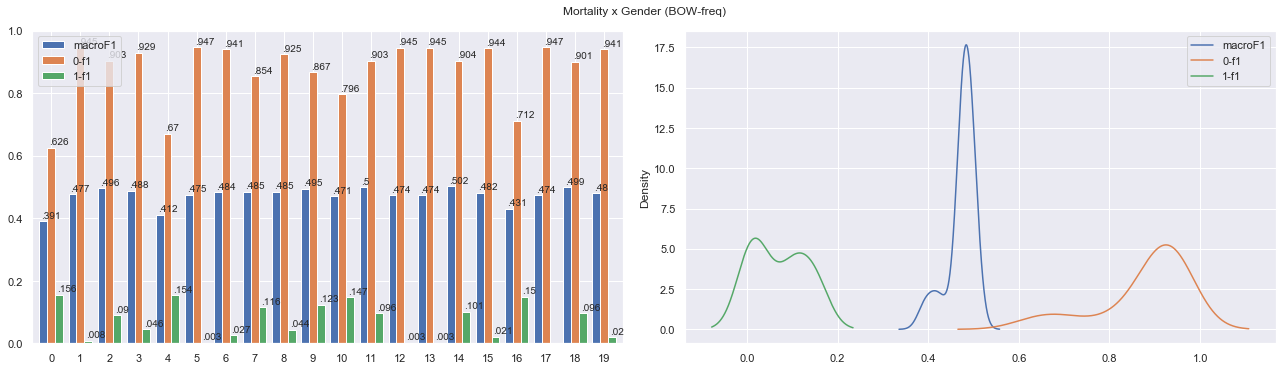

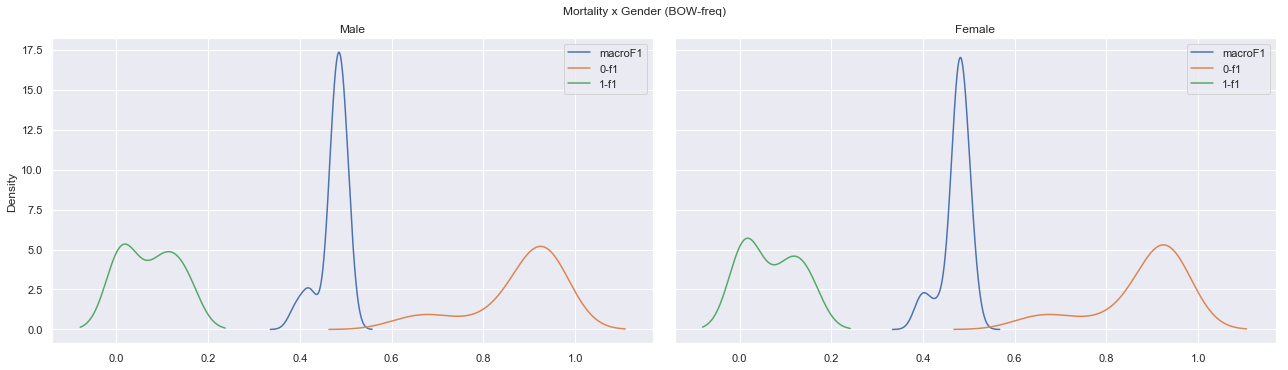

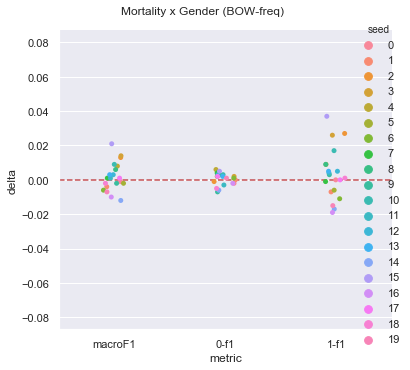

In [8]:
gender_analysis(data_path,"mortality","TEXT","EXPIRE", "BOW-freq", "Mortality x Gender")

WHITE: 5082 | others: 2086
NON-WHITE: 1141 | others: 6027


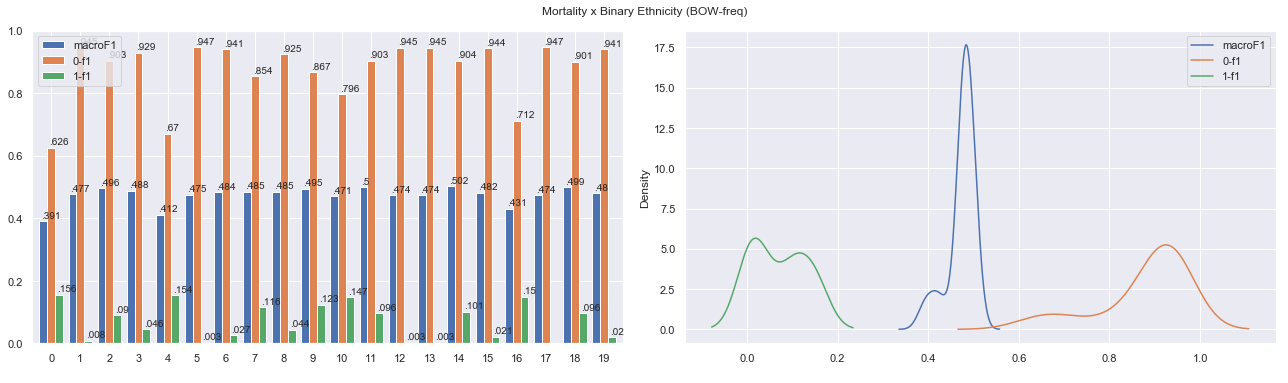

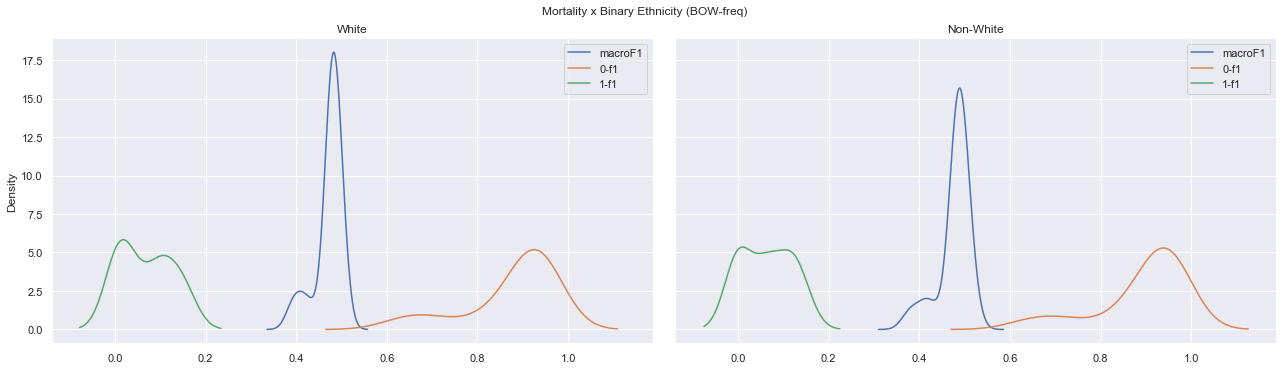

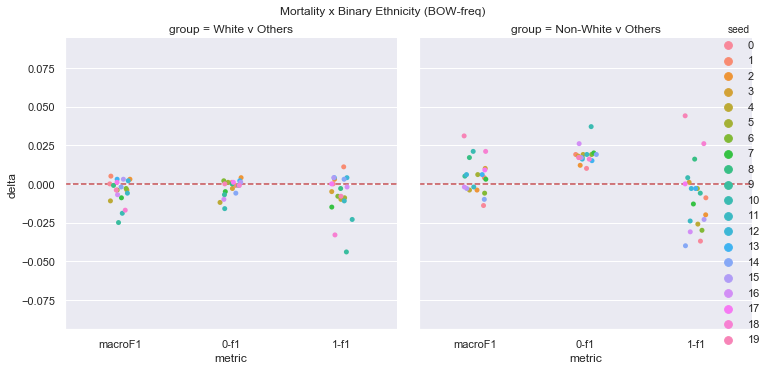

In [9]:
ethnicity_binary_analysis(data_path,"mortality","TEXT","EXPIRE", "BOW-freq", "Mortality x Binary Ethnicity")

WHITE: 5082 | others: 2086
BLACK: 675 | others: 6493
ASIAN: 215 | others: 6953
HISPANIC: 242 | others: 6926


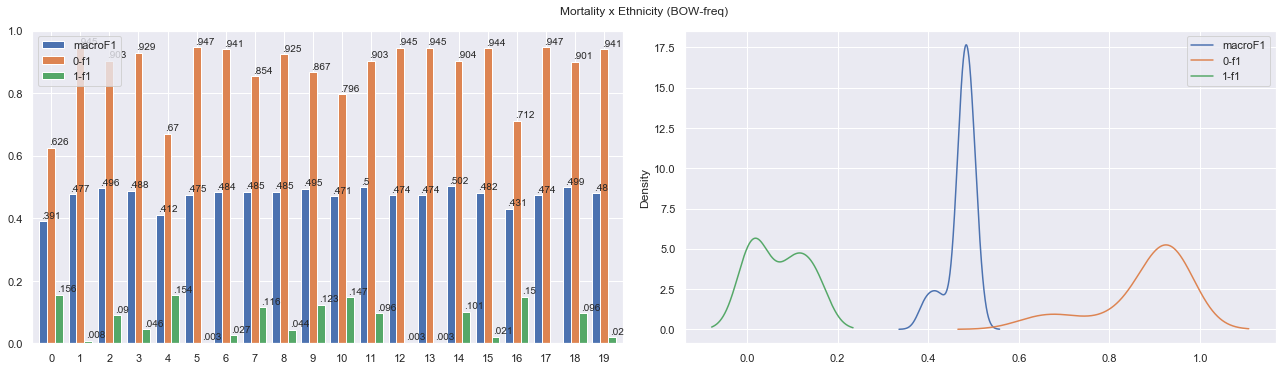

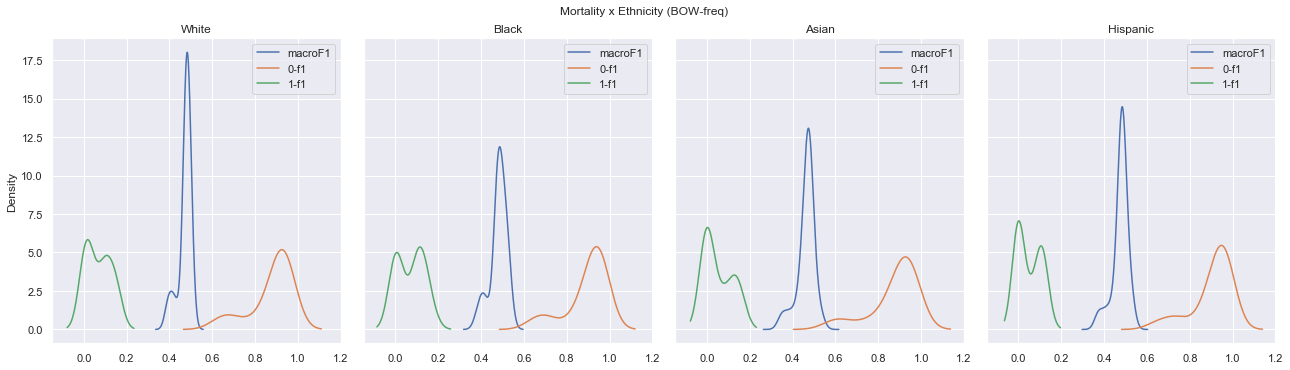

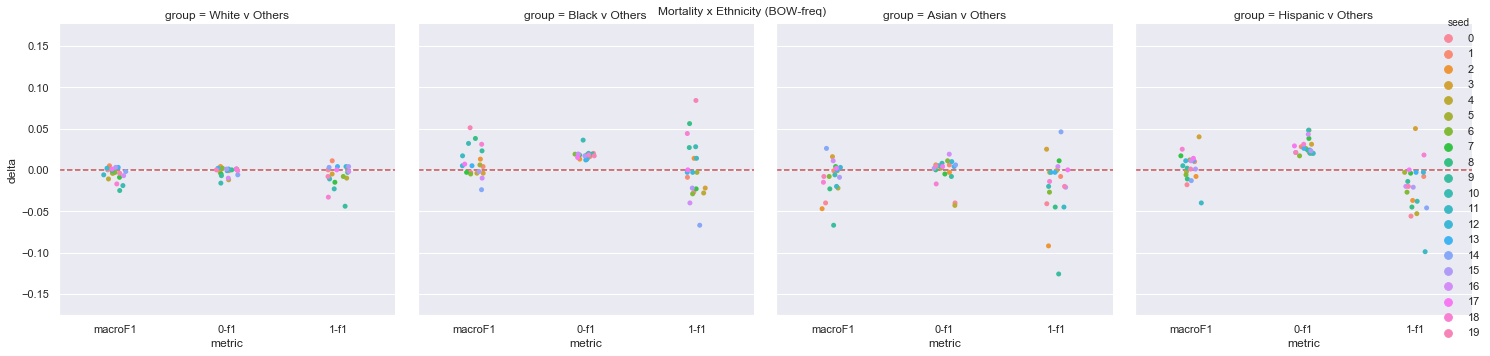

In [10]:
ethinicity_analysis(data_path,"mortality","TEXT","EXPIRE", "BOW-freq", "Mortality x Ethnicity")

## readmissions


M: 4024 | others: 3144


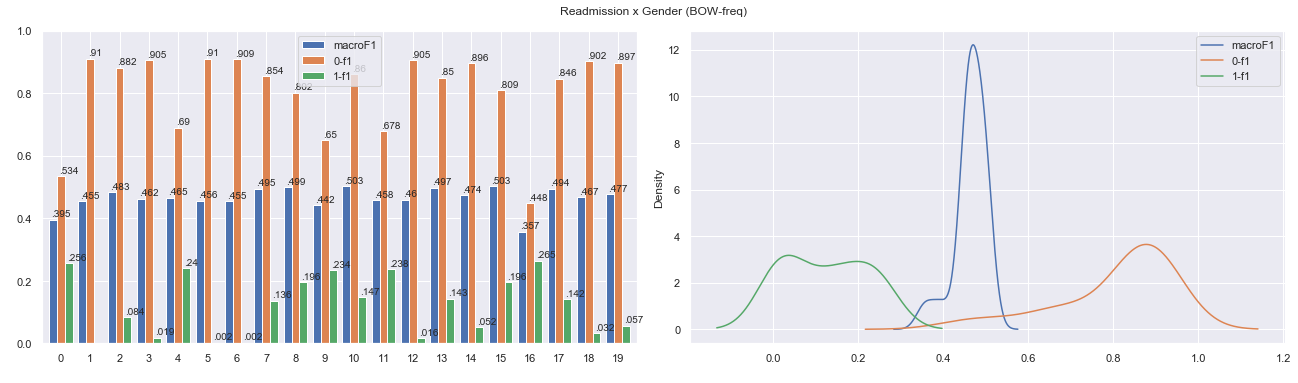

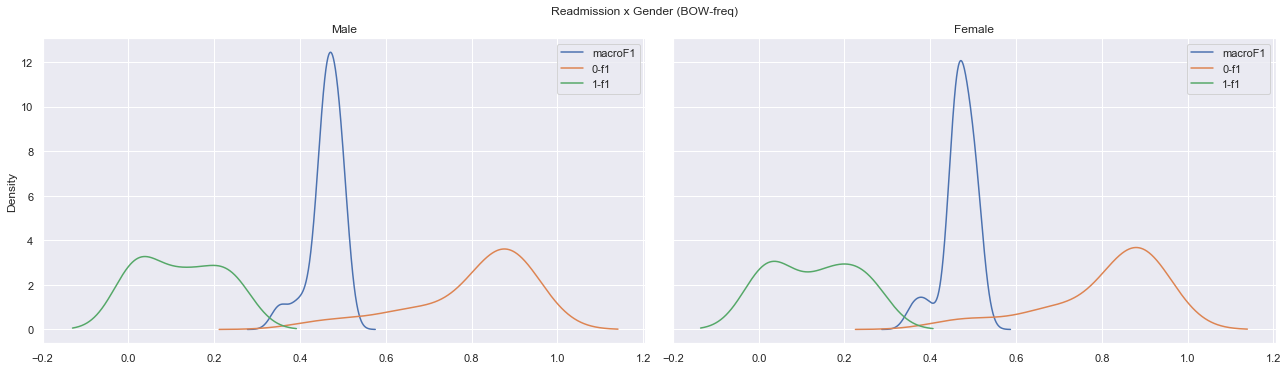

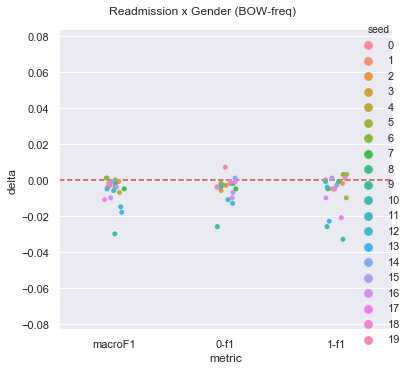

In [11]:
gender_analysis(data_path,"readmissions","TEXT","READMISSION", "BOW-freq", "Readmission x Gender")

WHITE: 4234 | others: 2934
BLACK: 572 | others: 6596
ASIAN: 172 | others: 6996
HISPANIC: 202 | others: 6966


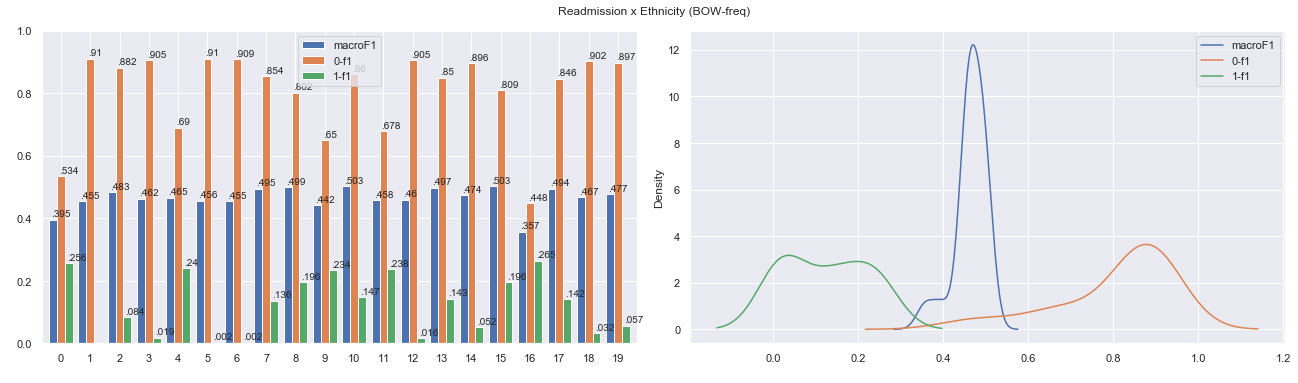

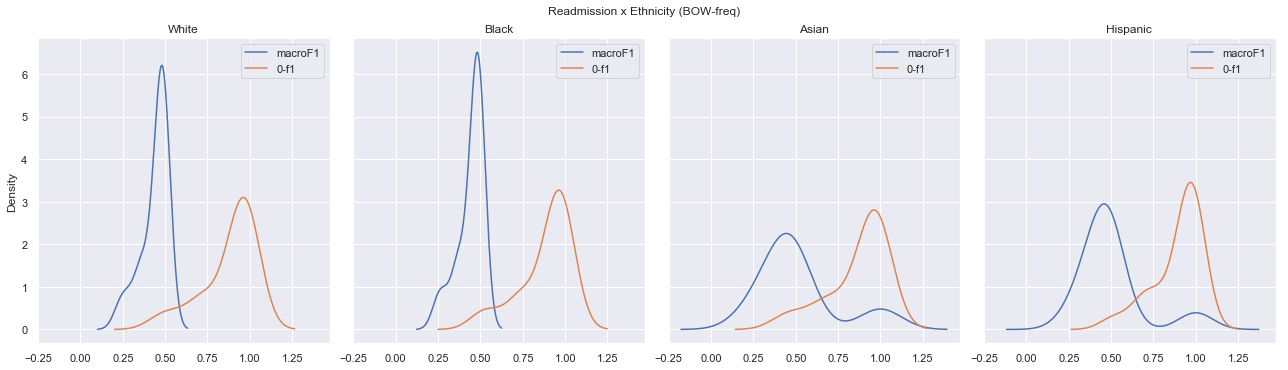

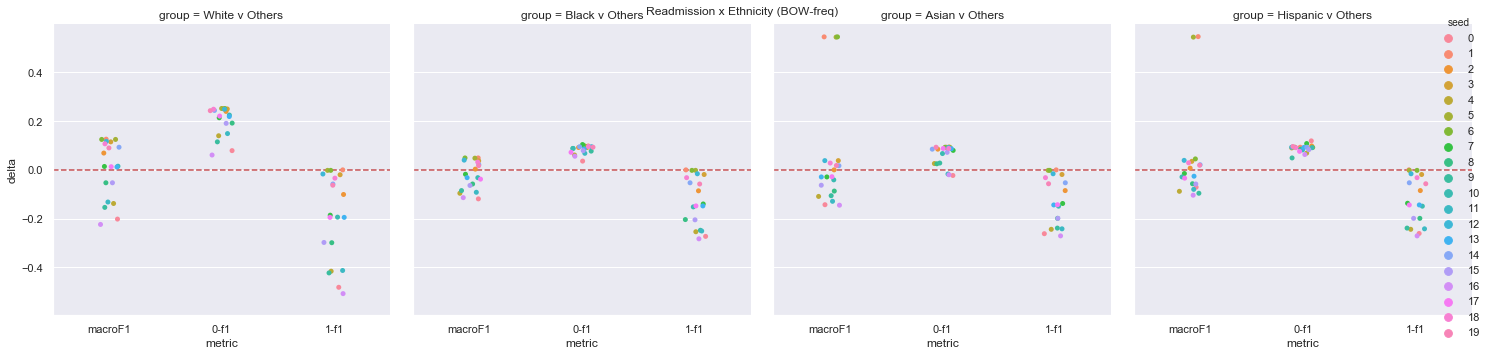

In [12]:
ethinicity_analysis(data_path,"readmissions","TEXT","READMISSION", "BOW-freq", "Readmission x Ethnicity")

WHITE: 4234 | others: 2934
NON-WHITE: 955 | others: 6213


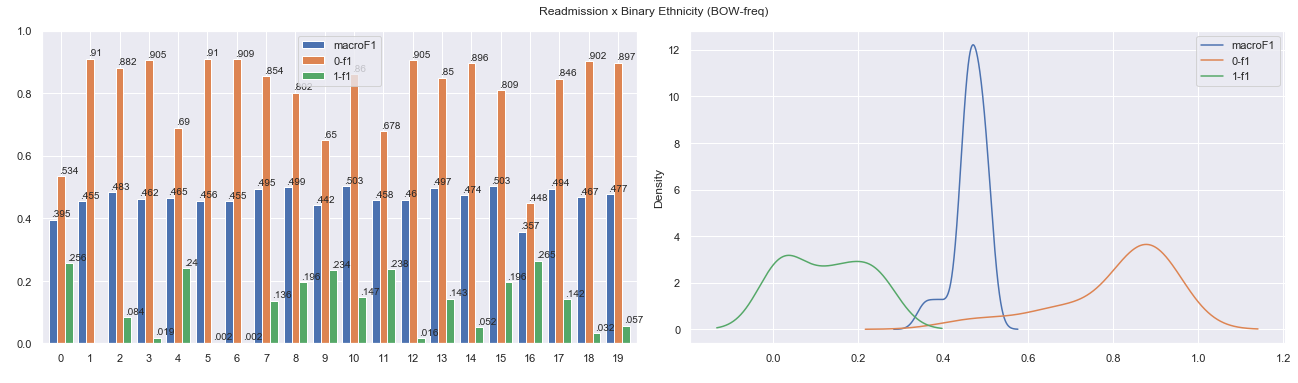

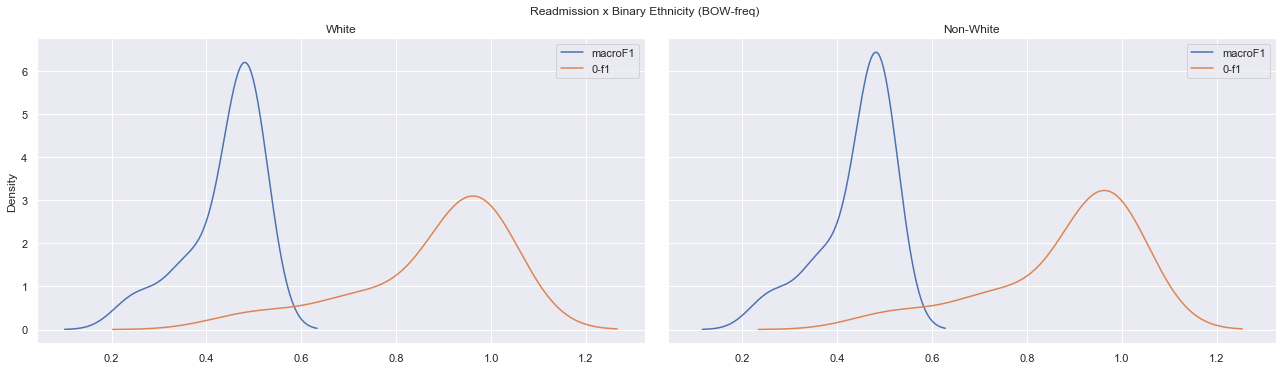

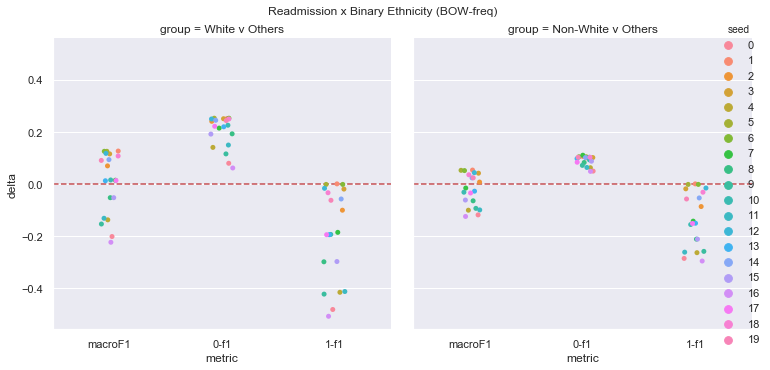

In [13]:
ethnicity_binary_analysis(data_path,"readmissions","TEXT","READMISSION", "BOW-freq", "Readmission x Binary Ethnicity")

# Manual Analysis

In [14]:
# # df_readmission = pd.read_csv(out_data_path+"readmissions.csv",sep="\t", header=None, names=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
# df_readmission

NameError: name 'out_data_path' is not defined

In [ ]:
# x_label="TEXT"
# y_label="READMISSION"
# feature_type="BOW-freq"
# df=df_readmission
# #GENDER
# # df_res, df_res_M, df_res_F, df_res_delta = gender_outcome_anaylsis(df, x_label, y_label, feature_type)
# #ETHNICITY
# df_res, df_res_W, df_res_N, df_res_A, df_res_H, df_res_delta_W, df_res_delta_N,df_res_delta_A, df_res_delta_H  = ethinicity_outcome_anaylsis(df, x_label, y_label, feature_type)





In [ ]:
# title="test"
# #GENDER
# # gender_plot_performance(df_res, title)
# # gender_plot_densities(df_res_M, df_res_F, title)
# # gender_plot_deltas(df_res_delta, title)
# #ETHNICITY
# ethinicity_plot_performance(df_res, title)
# ethnicity_plot_densities(df_res_W, df_res_N, df_res_A, df_res_H, title)
# ethinicity_plot_deltas(df_res_delta_W, df_res_delta_N,df_res_delta_A,df_res_delta_H, title)